Imports

In [111]:
from google.colab import files 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

Importando os dados CSV

In [86]:
dados = pd.read_csv('Bicicletas.csv')
dados.shape 

(731, 3)

Primeiro Plot dos dados

Text(0, 0.5, 'Temperatura')

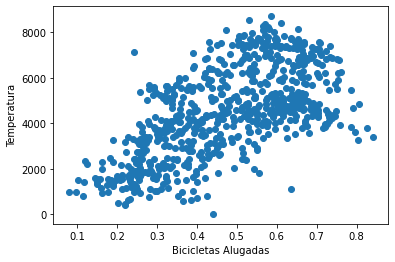

In [87]:
plt.scatter(dados['temperatura'],dados['bicicletas_alugadas'])
plt.xlabel('Bicicletas Alugadas')
plt.ylabel('Temperatura')

([<matplotlib.axis.XTick at 0x7fe9af736e50>,
 <a list of 3 Text major ticklabel objects>)

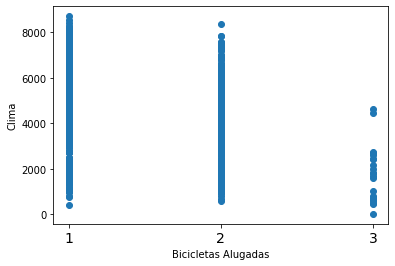

In [88]:
plt.scatter(dados['clima'],dados['bicicletas_alugadas'])
plt.xlabel('Bicicletas Alugadas')
plt.ylabel('Clima')
indice= [1,2,3]
plt.xticks(indice,fontsize=14)


In [101]:
y=dados['bicicletas_alugadas'].values
x=dados[['clima','temperatura']].values

X = x/np.amax(x,axis=0)
Y = y/np.amax(y,axis=0)
ymax = np.amax(y)


In [90]:
def sigmoid(soma):

  return 1/(1+np.exp(-soma)) 

In [91]:
def relu(soma):
  return np.maximum(0,soma)

In [92]:
arquitetura = [
     {"dim_entrada":2,"dim_saida":50,"ativacao":"relu"},
     {"dim_entrada":50,"dim_saida":1,"ativacao":"sigmoid"}          

]

Definindo uma função de arquitetura da rede neural 

In [93]:
def inicia_camadas(arquitetura, seed = 99):
    # inicia os valores aleatórios
    np.random.seed(seed)
    # numero de camadas da rede neural
    numero_de_camadas = len(arquitetura)
    # inicia armazenamento de parametros
    valores_parametros = {}
    
    # itera nas camadas da rede
    for indice, camada in enumerate(arquitetura):
        
        indice_camada = indice + 1
        
        # extrai o numero de nodos nas camadas
        tamanho_camada_entrada = camada["dim_entrada"]
        tamanho_camada_saida = camada["dim_saida"]
        
        # inicia os valores na matriz de pesos P
        # e o vetor de viés ou bias b
        valores_parametros['P' + str(indice_camada)] = np.random.randn(
            tamanho_camada_saida, tamanho_camada_entrada)  * 0.1
        valores_parametros['b' + str(indice_camada)] = np.random.randn(
            tamanho_camada_saida, 1) * 0.1
        
    return valores_parametros

Definindo função de propagação por camada 

In [94]:
def propaga_uma_camada(Ativado_anterior, Pesos_atual, b_atual, ativacao="relu"):
    # cálculo da entrada para a função de ativação
    Saida_atual = np.dot(Pesos_atual, Ativado_anterior) + b_atual
    
    # selecção da função de ativação
    if ativacao is "relu":
        func_ativacao = relu
    elif ativacao is "sigmoid":
        func_ativacao = sigmoid
    else:
        raise Exception('Ainda não implementamos essa funcao')
        
    # retorna a ativação calculada Ativado_atual e a matriz intermediária Saida
    return func_ativacao(Saida_atual), Saida_atual

Definindo função de propagação para múltiplas camadas 

In [95]:
def propaga_total(X, valores_parametros, arquitetura):
    # memoria temporaria para a retropropagacao
    memoria = {}
    # O vetor X é a ativação para a camada 0 
    Ativado_atual = X
    
    # iterações para as camadas
    for indice, camada in enumerate(arquitetura):
        # a numeração das camadas começa de 1
        indice_camada = indice + 1
        # utiliza a ativação da iteração anterior
        Ativado_anterior = Ativado_atual
        
        # extrai a função de ativação para a camada atual
        func_ativacao_atual = camada["ativacao"]
        # extrai os pesos da camada atual
        Pesos_atual = valores_parametros["P" + str(indice_camada)]
        # extrai o bias para a camada atual
        b_atual = valores_parametros["b" + str(indice_camada)]
        # cálculo da ativação para a camada atual
        Ativado_atual, Saida_atual = propaga_uma_camada(Ativado_anterior, Pesos_atual, b_atual, func_ativacao_atual)
        
        # salca os valores calculados na memória
        memoria["A" + str(indice)] = Ativado_anterior
        memoria["Z" + str(indice_camada)] = Saida_atual
       
    # retorna o vetor predito e um dicionário contendo os valores intermediários
    return Ativado_atual, memoria

In [96]:
valores_parametros =  inicia_camadas(arquitetura,seed=99)

In [97]:
y_estimado, memoria =  propaga_total(np.transpose(X),valores_parametros,arquitetura)

Testando a Rede Neural 

In [98]:
valores_parametros = inicia_camadas(arquitetura, seed = 99)
y_estimado, memoria = propaga_total(np.transpose(X), valores_parametros, arquitetura)

In [102]:
y_estimado[0,0]*ymax

4579.982967258466

In [103]:
y[0]*ymax

8583290

In [104]:
def atualiza(valores_parametros, gradidentes, arquitetura, taxa_aprendizagem):

    # iterações pelas camadas
    for indice_camada, camada in enumerate(arquitetura, 1):
        valores_parametros["P" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["dP" + str(indice_camada)]        
        valores_parametros["b" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["db" + str(indice_camada)]

    return valores_parametros;

Função de Custo 

In [105]:
def valor_de_custo(Y_predito, Y):
    # numero_de_exemplos
    m = Y_predito.shape[1]
    
    custo = -1 / m * (np.dot(Y, np.log(Y_predito).T) + np.dot(1 - Y, np.log(1 - Y_predito).T))
    return np.squeeze(custo)

In [106]:
def retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura):
   
    gradientes = {}
    
    # numero de exemplos
    #m = Y.shape[1]
    # para garantir que os dois vetores tenham a mesma dimensão
    Y = Y.reshape(Y_predito.shape)
    
    # inicia o algoritmo de gradiente descendente
    dAtivado_anterior = - (np.divide(Y, Y_predito) - np.divide(1 - Y, 1 - Y_predito));
    
    for indice_camada_anterior, camada in reversed(list(enumerate(arquitetura))):
        
        indice_camada_atual = indice_camada_anterior + 1
        # Função de ativação para a camada atual
        
        funcao_ativao_atual = camada["ativacao"]
        
        dAtivado_atual = dAtivado_anterior
        
        Ativado_anterior = memoria["A" + str(indice_camada_anterior)]
        Saida_atual = memoria["Z" + str(indice_camada_atual)]
        
        Pesos_atual = valores_parametros["P" + str(indice_camada_atual)]
        b_atual = valores_parametros["b" + str(indice_camada_atual)]
        
        dAtivado_anterior, dPesos_atual, db_atual = retropropagacao_uma_camada(
            dAtivado_atual, Pesos_atual, b_atual, Saida_atual, Ativado_anterior, funcao_ativao_atual)
        
        gradientes["dP" + str(indice_camada_atual)] = dPesos_atual
        gradientes["db" + str(indice_camada_atual)] = db_atual
    
    return gradientes

Definir as funções de ativação para a retropropagação

In [108]:
def sigmoid_retro(dAtivado, Saida):
    sig = sigmoid(Saida)
    return dAtivado * sig * (1 - sig)

def relu_retro(dAtivado, Saida):
    dSaida = np.array(dAtivado, copy = True)
    dSaida[Saida <= 0] = 0;
    return dSaida;

Retropropagação por camada 

In [107]:
def retropropagacao_uma_camada(dAtivado_atual, Pesos_atual, b_atual, Saida_atual, Ativado_anterior, ativacao="relu"):
    # número de exemplos
    m = Ativado_anterior.shape[1]
    
    # seleção função de ativação
    if ativacao is "relu":
        func_ativacao_retro = relu_retro
    elif ativacao is "sigmoid":
        func_ativacao_retro = sigmoid_retro
    else:
        raise Exception('Ainda não implementamos essa funcao')
    
    # derivada da função de ativação
    dSaida_atual = func_ativacao_retro(dAtivado_atual, Saida_atual)
    
    # derivada da matriz de Pesos
    dPesos_atual = np.dot(dSaida_atual, Ativado_anterior.T) / m
    # derivada do vetor b
    db_atual = np.sum(dSaida_atual, axis=1, keepdims=True) / m
    # derivada da matriz A_anterior
    dAtivado_anterior = np.dot(Pesos_atual.T, dSaida_atual)

    return dAtivado_anterior, dPesos_atual, db_atual

Treinamento da Rede

In [110]:
def treino(X, Y,X_teste,Y_teste, arquitetura, epocas, taxa_aprendizagem):
    # Inicia os parâmetros da rede neural
    valores_parametros = inicia_camadas(arquitetura, 2)
    # Listas que vão guardar o progresso da aprendizagem da rede 
    historia_custo = []
    historia_custo_teste = []
   
    
    # Atualiza a cada época
    for i in range(epocas):
        # Propaga a rede - Foward propagation
        Y_predito, memoria = propaga_total(X, valores_parametros, arquitetura)
        
        Y_predito_teste, memoria2 = propaga_total(X_teste, valores_parametros, 
                                                  arquitetura)
        
        # calcula as métricas e salva nas listas de história
        custo = valor_de_custo(Y_predito, Y)
        historia_custo.append(custo)
        custo_teste = valor_de_custo(Y_predito_teste, Y_teste)
        historia_custo_teste.append(custo_teste)
        
        
        # Retropropagação - Backpropagation
        gradientes = retropropagacao_total(Y_predito, Y, memoria, 
                                           valores_parametros, arquitetura)
        # Atualiza os pesos
        valores_parametros = atualiza(valores_parametros, gradientes, 
                                      arquitetura, taxa_aprendizagem)
        
        if(i % 50 == 0):
            
            print("Iteração: {:05} - custo: {:.5f} ".format(i, custo))
            
            
    return valores_parametros, historia_custo, historia_custo_teste

In [112]:
X_treino, X_teste, y_treino, y_teste = train_test_split( X, y, test_size=0.43, random_state=42)

In [113]:
# Treinamento
valores_parametros, historia_custo, historia_custo_teste = treino(np.transpose(X_treino), np.transpose(y_treino.reshape((y_treino.shape[0], 1))), 
                                                                  np.transpose(X_teste), np.transpose(y_teste.reshape((y_teste.shape[0], 1))), 
                                                                  arquitetura, 20000, 0.01)

Iteração: 00000 - custo: -24.91276 
Iteração: 00050 - custo: nan 
Iteração: 00100 - custo: nan 
Iteração: 00150 - custo: nan 
Iteração: 00200 - custo: nan 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Iteração: 00250 - custo: nan 
Iteração: 00300 - custo: nan 
Iteração: 00350 - custo: nan 
Iteração: 00400 - custo: nan 
Iteração: 00450 - custo: nan 
Iteração: 00500 - custo: nan 
Iteração: 00550 - custo: nan 
Iteração: 00600 - custo: nan 
Iteração: 00650 - custo: nan 
Iteração: 00700 - custo: nan 
Iteração: 00750 - custo: nan 
Iteração: 00800 - custo: nan 
Iteração: 00850 - custo: nan 
Iteração: 00900 - custo: nan 
Iteração: 00950 - custo: nan 
Iteração: 01000 - custo: nan 
Iteração: 01050 - custo: nan 
Iteração: 01100 - custo: nan 
Iteração: 01150 - custo: nan 
Iteração: 01200 - custo: nan 
Iteração: 01250 - custo: nan 
Iteração: 01300 - custo: nan 
Iteração: 01350 - custo: nan 
Iteração: 01400 - custo: nan 
Iteração: 01450 - custo: nan 
Iteração: 01500 - custo: nan 
Iteração: 01550 - custo: nan 
Iteração: 01600 - custo: nan 
Iteração: 01650 - custo: nan 
Iteração: 01700 - custo: nan 
Iteração: 01750 - custo: nan 
Iteração: 01800 - custo: nan 
Iteração: 01850 - custo: nan 
Iteração: 

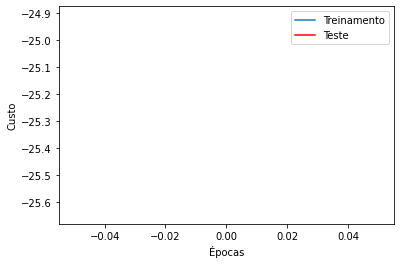

In [114]:
plt.plot(historia_custo)
plt.plot(historia_custo_teste, 'r')
plt.legend(['Treinamento','Teste'])
plt.ylabel('Custo')
plt.xlabel('Épocas')
plt.show()

Previsões com a Rede 

In [116]:
Y_pred, _ = propaga_total(np.transpose(X_teste), valores_parametros, arquitetura)

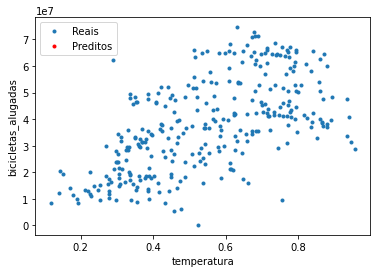

In [117]:
plt.plot(np.transpose(X_teste)[1],ymax*y_teste,'.')
plt.plot(np.transpose(X_teste)[1],ymax*Y_pred.reshape([-1,1]),'.r')
plt.legend(['Reais','Preditos'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('temperatura')
plt.show()

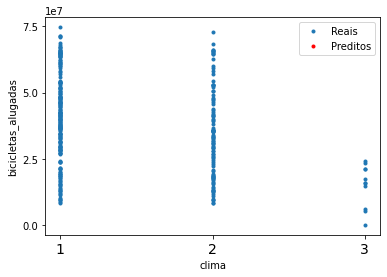

In [118]:
plt.plot(3*np.transpose(X_teste)[0],ymax*y_teste,'.')
plt.plot(3*np.transpose(X_teste)[0],ymax*Y_pred.reshape([-1,1]),'.r')
plt.legend(['Reais','Preditos'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('clima')
plt.rcParams.update({'font.size': 22})
indice=[1,2,3]
plt.xticks(indice, fontsize=14)
plt.show()